In [24]:
# === Setup & Imports ===
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from pypfopt.expected_returns import mean_historical_return
from pypfopt.risk_models import sample_cov
from pypfopt import EfficientFrontier, plotting
from datetime import datetime

# === Load historical price data ===
tickers = [
    "AKBNK.IS", "ARCLK.IS", "ASELS.IS", "BIMAS.IS", "EKGYO.IS",
    "KCHOL.IS", "ODAS.IS", "PGSUS.IS", "TCELL.IS", "THYAO.IS"
]

import yfinance as yf
hist_prices = yf.download(tickers, start="2020-01-01", end="2025-07-01", auto_adjust=True)["Close"]
hist_prices = hist_prices.dropna()

# === Load LSTM predictions ===
pred_df = pd.read_csv("C:/Users/USER/Desktop/portfolio_optimizer/data/lstm_predictions.csv")
pred_df["Ticker"] = pred_df["Ticker"].str.strip()
pred_df["Day"] = pred_df["Day"].astype(int)

# === Extract latest forecast data ===
latest_preds = pred_df[pred_df["Day"] == -1].set_index("Ticker")["Predicted"]
latest_actuals = pred_df[pred_df["Day"] == -1].set_index("Ticker")["Actual"]

# === Confirm data load ===
print("Historical price data shape:", hist_prices.shape)
print("\nSample of last predicted prices:")
print(latest_preds.head())


[*********************100%***********************]  10 of 10 completed

Historical price data shape: (1372, 10)

Sample of last predicted prices:
Ticker
AKBNK.IS     61.487007
ARCLK.IS    119.666626
ASELS.IS    144.319400
BIMAS.IS    472.800540
EKGYO.IS     16.812637
Name: Predicted, dtype: float64


Expected annual return: 141.0%
Annual volatility: 33.7%
Sharpe Ratio: 4.18
Expected annual return: 141.0%
Annual volatility: 33.7%
Sharpe Ratio: 4.18


C:\Users\USER\AppData\Roaming\Python\Python39\site-packages\pypfopt\efficient_frontier\efficient_frontier.py:259: UserWarning: max_sharpe transforms the optimization problem so additional objectives may not work as expected.
  warnings.warn(


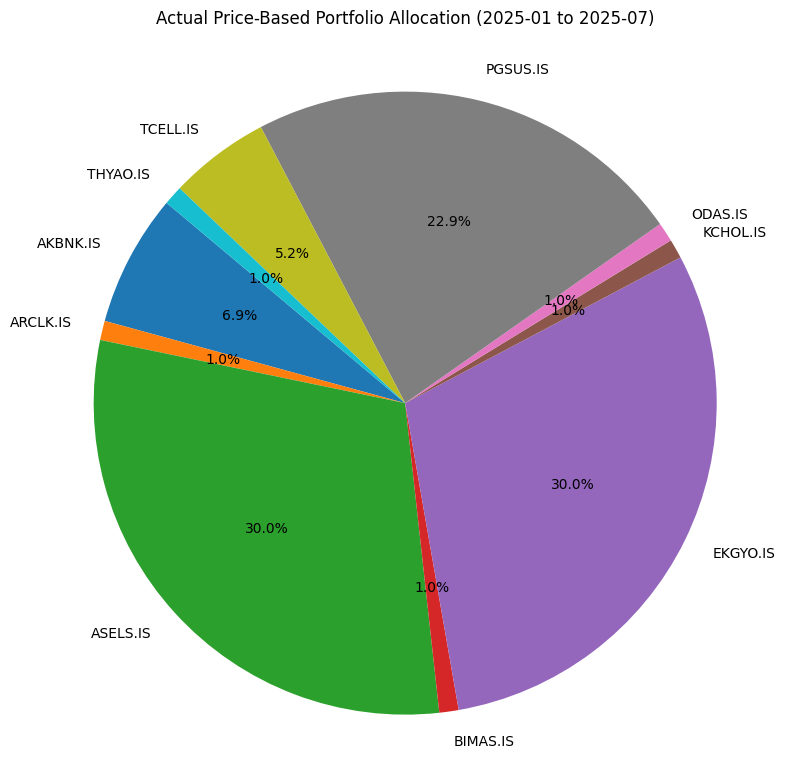

In [21]:
# === Filter the last 6 months of price data ===
hist_prices_recent = hist_prices[hist_prices.index >= "2025-01-01"]

# === Calculate expected returns and risk ===
from pypfopt.expected_returns import mean_historical_return
from pypfopt.risk_models import sample_cov

mu_actual = mean_historical_return(hist_prices_recent, frequency=252)
cov_actual = sample_cov(hist_prices_recent)

# === Optimize for Max Sharpe Ratio Portfolio ===
from pypfopt import EfficientFrontier

from pypfopt import objective_functions

ef_actual = EfficientFrontier(mu_actual, cov_actual, weight_bounds=(0.01, 0.30))  # Min 1%, max 30%
ef_actual.add_objective(objective_functions.L2_reg, gamma=0.1)  # Regularize toward equal weights
weights_actual = ef_actual.max_sharpe()
cleaned_weights_actual = ef_actual.clean_weights()
ret_actual, vol_actual, sharpe_actual = ef_actual.portfolio_performance(verbose=True)


cleaned_weights_actual = ef_actual.clean_weights()

# === Portfolio performance metrics ===
ret_actual, vol_actual, sharpe_actual = ef_actual.portfolio_performance(verbose=True)

# === Visualization: Pie chart of allocations ===
import matplotlib.pyplot as plt

plt.figure(figsize=(8, 8))
plt.pie(
    cleaned_weights_actual.values(),
    labels=cleaned_weights_actual.keys(),
    autopct="%1.1f%%",
    startangle=140
)
plt.title("Actual Price-Based Portfolio Allocation (2025-01 to 2025-07)")
plt.axis("equal")
plt.tight_layout()
plt.show()



Expected annual return: 13.3%
Annual volatility: 34.0%
Sharpe Ratio: 0.39
Expected annual return: 13.3%
Annual volatility: 34.0%
Sharpe Ratio: 0.39


C:\Users\USER\AppData\Roaming\Python\Python39\site-packages\pypfopt\efficient_frontier\efficient_frontier.py:259: UserWarning: max_sharpe transforms the optimization problem so additional objectives may not work as expected.
  warnings.warn(


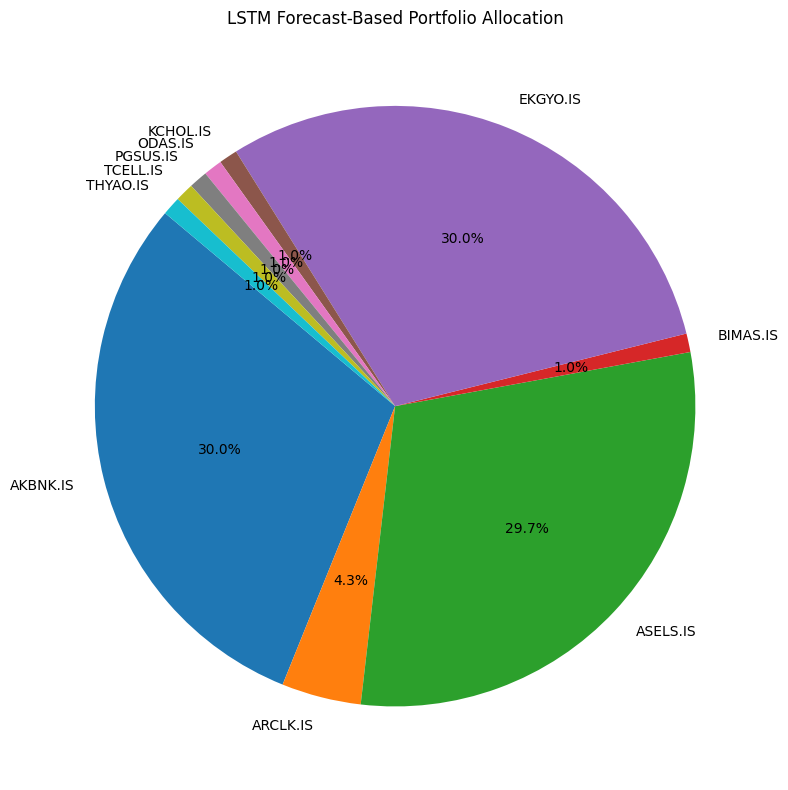

In [23]:
# === Load predicted returns ===
# (Assumes you've already loaded pred_df from earlier)

# Pivot so we have wide format: Day as rows, Ticker as columns
pred_wide = pred_df.pivot(index="Day", columns="Ticker", values="Predicted")

# Calculate predicted 30-day return per ticker
pred_30day_return = (pred_wide.loc[-1] - pred_wide.loc[-30]) / pred_wide.loc[-30]
mu_pred_daily = (1 + pred_30day_return) ** (1/30) - 1
mu_pred_annual = (1 + mu_pred_daily) ** 252 - 1

# === Reuse the same historical covariance matrix ===
# (from Part 2: based on Jan–July 2025 prices)
# Note: You could scale it down if you want, but using it directly is common

# === Optimize portfolio based on predicted returns ===
ef_pred = EfficientFrontier(mu_predicted, cov_actual, weight_bounds=(0.01, 0.30))
ef_pred.add_objective(objective_functions.L2_reg, gamma=0.1)
weights_pred = ef_pred.max_sharpe()
cleaned_weights_pred = ef_pred.clean_weights()
ret_pred, vol_pred, sharpe_pred = ef_pred.portfolio_performance(verbose=True)

cleaned_weights_pred = ef_pred.clean_weights()

# === Portfolio performance (based on predicted μ + historical Σ) ===
ret_pred, vol_pred, sharpe_pred = ef_pred.portfolio_performance(verbose=True)

# === Plot pie chart ===
plt.figure(figsize=(8, 8))
plt.pie(
    cleaned_weights_pred.values(),
    labels=cleaned_weights_pred.keys(),
    autopct="%1.1f%%",
    startangle=140
)
plt.title("LSTM Forecast-Based Portfolio Allocation")
plt.axis("equal")
plt.tight_layout()
plt.show()

